In [1]:
import pandas as pd
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
import string
import nltk
from nltk.util import bigrams, trigrams
from nltk.corpus import stopwords
from gensim.models import Word2Vec #install gensim # had to use this: pip install --upgrade gensim smart_open protobuf==3.20.0
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from scipy.stats import chi2_contingency


In [2]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /Users/ethan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ethan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/ethan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/ethan/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/ethan/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ethan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ethan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
data = pd.read_pickle('data/data_cleaned.pkl')

In [4]:
data.head()

,comment,parent_comment,label
0,just shoot some unarmed black guy and get paid...,"a pregnant police officer asked for ""light dut...",1
1,that is like saying the relative weakness or i...,"well, no, it is better. just not ideal. it is ...",0
2,except pluto would not give us any cool space ...,we would live out destiny as pluto would becom...,0
3,"you are probably right, it is more like: ""oh, ...",i really do not think they feel even a little ...,0
4,"or that 85 hour working abroad pipeline money,...",i am talkin bout that veterans day pay that th...,0


### Tokenizing  
Do N-grams at this step

In [4]:
def tokenize_text(text, ngram='unigram'):
    tokens = nltk.word_tokenize(text)
    
    if ngram == 'unigram':
        return tokens
    elif ngram == 'bigram':
        return list(bigrams(tokens))
    elif ngram == 'trigram':
        return list(trigrams(tokens))
    else:
        raise ValueError("ngram should be either 'unigram', 'bigram', or 'trigram'")

# Unigram Tokenizing
data["comment_tokens"] = data["comment"].apply(lambda x: tokenize_text(x, 'unigram'))
data["parent_comment_tokens"] = data["parent_comment"].apply(lambda x: tokenize_text(x, 'unigram'))

# Bigram Tokenizing
data["comment_tokens_bigram"] = data["comment"].apply(lambda x: tokenize_text(x, 'bigram'))
data["parent_comment_tokens_bigram"] = data["parent_comment"].apply(lambda x: tokenize_text(x, 'bigram'))

# Trigram Tokenizing
data["comment_tokens_trigram"] = data["comment"].apply(lambda x: tokenize_text(x, 'trigram'))
data["parent_comment_tokens_trigram"] = data["parent_comment"].apply(lambda x: tokenize_text(x, 'trigram'))

In [ ]:
"""
#spellchecking
#%pip install pyspellchecker
from spellchecker import SpellChecker
spell = SpellChecker()
data['comment_tokens'] = data['comment_tokens'].apply(lambda tokens: [spell.correction(token) for token in tokens])
data['parent_comment_tokens'] = data['parent_comment_tokens'].apply(lambda tokens: [spell.correction(token) for token in tokens])
"""

### Removing Stop Words

In [5]:
#remove possible words from stop_words that can change meaning of text
stop_words = set(stopwords.words('english'))

to_remove = ["no","not"]
for word in to_remove:
    stop_words.remove(word)
# Filtering function for unigrams
def filter_unigrams(tokens):
    return [token for token in tokens if token not in stop_words]

# Filtering function for bigrams
def filter_bigrams(bigram_tokens):
    return [bigram for bigram in bigram_tokens if not all(word in stop_words for word in bigram)]

# Filtering function for trigrams
def filter_trigrams(trigram_tokens):
    return [trigram for trigram in trigram_tokens if not all(word in stop_words for word in trigram)]

# Apply the filtering functions
data["comment_tokens"] = data["comment_tokens"].apply(filter_unigrams)
data["parent_comment_tokens"] = data["parent_comment_tokens"].apply(filter_unigrams)

data["comment_tokens_bigram"] = data["comment_tokens_bigram"].apply(filter_bigrams)
data["parent_comment_tokens_bigram"] = data["parent_comment_tokens_bigram"].apply(filter_bigrams)

data["comment_tokens_trigram"] = data["comment_tokens_trigram"].apply(filter_trigrams)
data["parent_comment_tokens_trigram"] = data["parent_comment_tokens_trigram"].apply(filter_trigrams)

### Lemmatization

In [6]:
lemmatizer = WordNetLemmatizer()
# Lemmatize function for unigrams
def lemmatize_unigrams(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Lemmatize function for bigrams
def lemmatize_bigrams(bigram_tokens):
    return [' '.join([lemmatizer.lemmatize(word) for word in bigram]) for bigram in bigram_tokens]

# Lemmatize function for trigrams
def lemmatize_trigrams(trigram_tokens):
    return [' '.join([lemmatizer.lemmatize(word) for word in trigram]) for trigram in trigram_tokens]

# Apply the lemmatize functions
data["comment_tokens"] = data["comment_tokens"].apply(lemmatize_unigrams)
data["parent_comment_tokens"] = data["parent_comment_tokens"].apply(lemmatize_unigrams)

data["comment_tokens_bigram"] = data["comment_tokens_bigram"].apply(lemmatize_bigrams)
data["parent_comment_tokens_bigram"] = data["parent_comment_tokens_bigram"].apply(lemmatize_bigrams)

data["comment_tokens_trigram"] = data["comment_tokens_trigram"].apply(lemmatize_trigrams)
data["parent_comment_tokens_trigram"] = data["parent_comment_tokens_trigram"].apply(lemmatize_trigrams)

### Sentiment Analysis

In [7]:
sia = SentimentIntensityAnalyzer()
data['comment_score'] = data['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
data['parent_comment_score'] = data['parent_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])

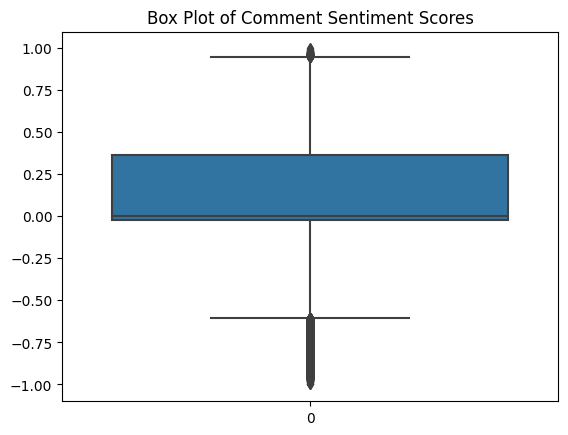

In [15]:
sns.boxplot(data['comment_score'])
plt.title('Box Plot of Comment Sentiment Scores')
plt.show()

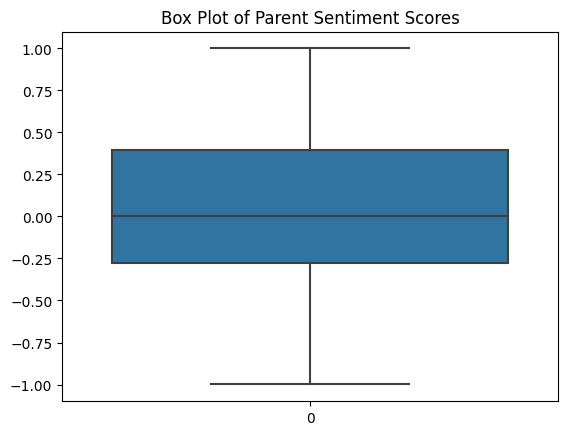

In [16]:
sns.boxplot(data['parent_comment_score'])
plt.title('Box Plot of Parent Sentiment Scores')
plt.show()

/var/folders/0t/661fss3n2h53fsp71dq_blsm0000gn/T/ipykernel_17303/2726375268.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['comment_score'], shade=True, color = 'blue')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/0t/661fss3n2h53fsp71dq_blsm0000gn/T/ipykernel_17303/2726375268.py:2: FutureWarning: 

`s

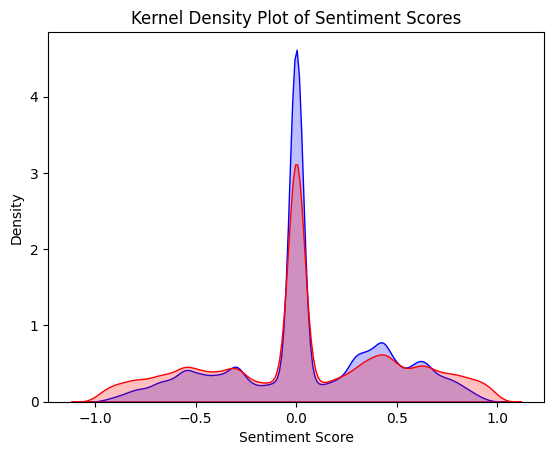

In [17]:
sns.kdeplot(data['comment_score'], shade=True, color = 'blue')
sns.kdeplot(data['parent_comment_score'], shade = True, color='red')
plt.title('Kernel Density Plot of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

In [8]:
def sentiment(score):
    if (score >= 0.25):
        return 'positive'
    elif (score <= -0.25):
        return 'negative'
    else:
        return 'neutral'
    
data['weighted_comment_sentiment_score'] = data['comment_score'].apply(sentiment)
data['weighted_parent_sentiment_score'] = data['parent_comment_score'].apply(sentiment)
data.head()

,comment,parent_comment,label,comment_tokens,parent_comment_tokens,comment_tokens_bigram,parent_comment_tokens_bigram,comment_tokens_trigram,parent_comment_tokens_trigram,comment_score,parent_comment_score,weighted_comment_sentiment_score,weighted_parent_sentiment_score
0,just shoot some unarmed black guy and get paid...,"a pregnant police officer asked for ""light dut...",1,"[shoot, unarmed, black, guy, get, paid, leave, .]","[pregnant, police, officer, asked, ``, light, ...","[just shoot, shoot some, some unarmed, unarmed...","[a pregnant, pregnant police, police officer, ...","[just shoot some, shoot some unarmed, some una...","[a pregnant police, pregnant police officer, p...",-0.3818,-0.0523,negative,neutral
1,that is like saying the relative weakness or i...,"well, no, it is better. just not ideal. it is ...",0,"[like, saying, relative, weakness, ineffective...","[well, ,, no, ,, better, ., not, ideal, ., lot...","[is like, like saying, saying the, the relativ...","[well ,, , no, no ,, , it, is better, better ....","[that is like, is like saying, like saying the...","[well , no, , no ,, no , it, , it is, it is be...",-0.8126,-0.5709,negative,negative
2,except pluto would not give us any cool space ...,we would live out destiny as pluto would becom...,0,"[except, pluto, would, not, give, u, cool, spa...","[would, live, destiny, pluto, would, become, t...","[except pluto, pluto would, would not, not giv...","[we would, would live, live out, out destiny, ...","[except pluto would, pluto would not, would no...","[we would live, would live out, live out desti...",0.3182,0.0000,positive,neutral
3,"you are probably right, it is more like: ""oh, ...",i really do not think they feel even a little ...,0,"[probably, right, ,, like, :, ``, oh, ,, know,...","[really, not, think, feel, even, little, guilt...","[are probably, probably right, right ,, , it, ...","[i really, really do, do not, not think, think...","[you are probably, are probably right, probabl...","[i really do, really do not, do not think, not...",0.4643,-0.7848,positive,negative
4,"or that 85 hour working abroad pipeline money,...",i am talkin bout that veterans day pay that th...,0,"[85, hour, working, abroad, pipeline, money, ,...","[talkin, bout, veteran, day, pay, thanksgiving...","[that 85, 85 hour, hour working, working abroa...","[am talkin, talkin bout, bout that, that veter...","[or that 85, that 85 hour, 85 hour working, ho...","[i am talkin, am talkin bout, talkin bout that...",-0.6428,-0.2023,negative,neutral


In [9]:
contingency_table = pd.crosstab(data['label'], data['weighted_comment_sentiment_score'])

# Display the contingency table
print(contingency_table)

weighted_comment_sentiment_score  negative  neutral  positive
label                                                        
0                                    18883    52057     30025
1                                    21556    45973     33529


In [20]:
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f'Chi-Square Value: {chi2}')
print(f'P-value: {p}')

Chi-Square Value: 747.420822690915
P-value: 5.007610286465115e-163


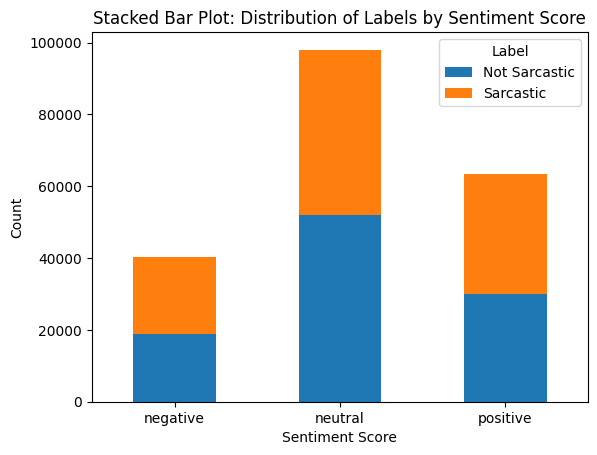

In [21]:
stacked_data = data.groupby(['weighted_comment_sentiment_score', 'label']).size().unstack().fillna(0)

stacked_data.plot(kind='bar', stacked=True)
plt.title('Stacked Bar Plot: Distribution of Labels by Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Label', labels=['Not Sarcastic', 'Sarcastic'])
plt.show()

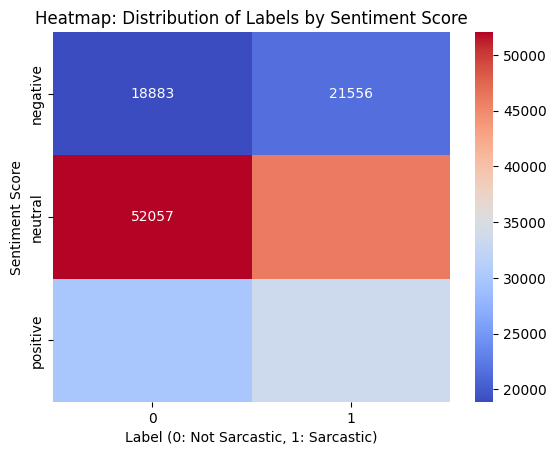

In [22]:
heatmap_data = data.groupby(['weighted_comment_sentiment_score', 'label']).size().unstack().fillna(0)
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm')
plt.title('Heatmap: Distribution of Labels by Sentiment Score')
plt.xlabel('Label (0: Not Sarcastic, 1: Sarcastic)')
plt.ylabel('Sentiment Score')
plt.show()

In [10]:
# One Hot Encode Weighted Sentiment Scores
data = pd.get_dummies(data, columns = ['weighted_parent_sentiment_score','weighted_comment_sentiment_score'], drop_first=True)

In [24]:
data.head()

,comment,parent_comment,label,comment_tokens,parent_comment_tokens,comment_tokens_bigram,parent_comment_tokens_bigram,comment_tokens_trigram,parent_comment_tokens_trigram,comment_score,parent_comment_score,weighted_parent_sentiment_score_neutral,weighted_parent_sentiment_score_positive,weighted_comment_sentiment_score_neutral,weighted_comment_sentiment_score_positive
0,just shoot some unarmed black guy and get paid...,"a pregnant police officer asked for ""light dut...",1,"[shoot, unarmed, black, guy, get, paid, leave, .]","[pregnant, police, officer, asked, ``, light, ...","[just shoot, shoot some, some unarmed, unarmed...","[a pregnant, pregnant police, police officer, ...","[just shoot some, shoot some unarmed, some una...","[a pregnant police, pregnant police officer, p...",-0.3818,-0.0523,True,False,False,False
1,that is like saying the relative weakness or i...,"well, no, it is better. just not ideal. it is ...",0,"[like, saying, relative, weakness, ineffective...","[well, ,, no, ,, better, ., not, ideal, ., lot...","[is like, like saying, saying the, the relativ...","[well ,, , no, no ,, , it, is better, better ....","[that is like, is like saying, like saying the...","[well , no, , no ,, no , it, , it is, it is be...",-0.8126,-0.5709,False,False,False,False
2,except pluto would not give us any cool space ...,we would live out destiny as pluto would becom...,0,"[except, pluto, would, not, give, u, cool, spa...","[would, live, destiny, pluto, would, become, t...","[except pluto, pluto would, would not, not giv...","[we would, would live, live out, out destiny, ...","[except pluto would, pluto would not, would no...","[we would live, would live out, live out desti...",0.3182,0.0000,True,False,False,True
3,"you are probably right, it is more like: ""oh, ...",i really do not think they feel even a little ...,0,"[probably, right, ,, like, :, ``, oh, ,, know,...","[really, not, think, feel, even, little, guilt...","[are probably, probably right, right ,, , it, ...","[i really, really do, do not, not think, think...","[you are probably, are probably right, probabl...","[i really do, really do not, do not think, not...",0.4643,-0.7848,False,False,False,True
4,"or that 85 hour working abroad pipeline money,...",i am talkin bout that veterans day pay that th...,0,"[85, hour, working, abroad, pipeline, money, ,...","[talkin, bout, veteran, day, pay, thanksgiving...","[that 85, 85 hour, hour working, working abroa...","[am talkin, talkin bout, bout that, that veter...","[or that 85, that 85 hour, 85 hour working, ho...","[i am talkin, am talkin bout, talkin bout that...",-0.6428,-0.2023,True,False,False,False


### Basic Text Features
- extracted these features mostly from the original sentences
- extracted token count, unique token count and mean token length

In [11]:
#data = data[['label','comment', 'parent_comment']]
###pre-tokenised###
# Word Count
data['comment_word_count'] = data['comment'].apply(lambda x: len(str(x).split()))
data['parent_comment_word_count'] = data['parent_comment'].apply(lambda x: len(str(x).split()))
data['comment_token_count'] = data['comment_tokens'].apply(lambda x: len(x))
data['parent_comment_token_count'] = data['parent_comment_tokens'].apply(lambda x: len(x))

# Unique Word Count
data['comment_unique_word_count'] = data['comment'].apply(lambda x: len(set(str(x).split())))
data['parent_comment_unique_word_count'] = data['parent_comment'].apply(lambda x: len(set(str(x).split())))
data['comment_unique_token_count'] = data['comment_tokens'].apply(lambda x: len(set(x)))
data['parent_comment_unique_token_count'] = data['parent_comment_tokens'].apply(lambda x: len(set(x)))

# Stop Word Count
stop = stopwords.words('english')
data['comment_stopword_count'] = data['comment'].apply(lambda x: len([word for word in str(x).split() if word.lower() in stop]))
data['parent_comment_stopword_count'] = data['parent_comment'].apply(lambda x: len([word for word in str(x).split() if word.lower() in stop]))

# Mean Word Length
data['comment_mean_word_length'] = data['comment'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
data['parent_comment_mean_word_length'] = data['parent_comment'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
data['comment_mean_token_length'] = data['comment_tokens'].apply(lambda x: np.mean([len(token) for token in x]))
data['parent_comment_mean_token_length'] = data['parent_comment_tokens'].apply(lambda x: np.mean([len(token) for token in x]))

# Character Count
data['comment_char_count'] = data['comment'].apply(lambda x: len(str(x)))
data['parent_comment_char_count'] = data['parent_comment'].apply(lambda x: len(str(x)))

# Punctuation Count
data['comment_punctuation_count'] = data['comment'].apply(lambda x: len([char for char in str(x) if char in string.punctuation]))
data['parent_comment_punctuation_count'] = data['parent_comment'].apply(lambda x: len([char for char in str(x) if char in string.punctuation]))

# Hashtag and Number Count
data['comment_hashtag_count'] = data['comment'].apply(lambda x: len([word for word in str(x).split() if word.startswith('#')]))
data['parent_comment_hashtag_count'] = data['parent_comment'].apply(lambda x: len([word for word in str(x).split() if word.startswith('#')]))

data['comment_number_count'] = data['comment'].apply(lambda x: len([word for word in str(x).split() if word.isdigit()]))
data['parent_comment_number_count'] = data['parent_comment'].apply(lambda x: len([word for word in str(x).split() if word.isdigit()]))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype

### Bag of Words

In [12]:
documents_comments = data['comment_tokens'].apply(lambda tokens_list:' '.join(tokens_list))
documents_parent_comments = data['parent_comment_tokens'].apply(lambda tokens_list:' '.join(tokens_list))

In [13]:
# For comments
vectorizer_comments = CountVectorizer(min_df=4, ngram_range=(1, 3))
bow_matrix_comments = vectorizer_comments.fit_transform(documents_comments)
bow_matrix_csr = csr_matrix(bow_matrix_comments)
data['comment_bow'] = [row for row in bow_matrix_csr]

# For parent comments
vectorizer_parent_comments = CountVectorizer(min_df=4, ngram_range=(1, 3))
bow_matrix_parent_comments = vectorizer_parent_comments.fit_transform(documents_parent_comments)
bow_matrix_csr_parent = csr_matrix(bow_matrix_parent_comments)
data['parent_comment_bow'] = [row for row in bow_matrix_csr_parent]


In [14]:
### Function to extract feature names from CSR representation
feature_names_bow = vectorizer_comments.get_feature_names_out() # to reverse
def bow_to_words(bow_vector, feature_names):
    # Convert the sparse matrix row to a dense array
    array = bow_vector.toarray().flatten()
    # Get the tokens that have a count > 0
    tokens = [feature_names[i] for i, count in enumerate(array) if count > 0]
    return tokens

In [33]:
bow_to_words(data['comment_bow'].iloc[0],feature_names_bow) # we see that the trigrams are not present in this one example- likely due to the trigrams being much more rare.

['black',
 'black guy',
 'get',
 'get paid',
 'guy',
 'guy get',
 'leave',
 'paid',
 'shoot',
 'shoot unarmed',
 'unarmed',
 'unarmed black']

### TD-IDF

In [15]:
tdvectorizer_comments = TfidfVectorizer(min_df = 4, ngram_range=(1, 3))
tdidf_matrix_comments = tdvectorizer_comments.fit_transform(documents_comments)
tdidf_matrix_csr = csr_matrix(tdidf_matrix_comments)
data['comment_tdidf'] = [row for row in tdidf_matrix_csr]

tdvectorizer_parent_comments = TfidfVectorizer(min_df = 4, ngram_range=(1, 3))
tdidf_matrix_parent_comments = tdvectorizer_parent_comments.fit_transform(documents_parent_comments)
tdidf_matrix_csr_parent = csr_matrix(tdidf_matrix_parent_comments)
data['parent_comment_tdidf'] = [row for row in tdidf_matrix_csr_parent]

In [17]:
feature_names_tfidf = tdvectorizer_comments.get_feature_names_out()
def tfidf_to_words(tfidf_row, feature_names):
    """
    Convert a TF-IDF row to its word representation.
    :param tfidf_row: A single row from a sparse matrix.
    :param feature_names: List of feature names from the TF-IDF vectorizer.
    :return: List of words from the TF-IDF row.
    """
    dense_tfidf = tfidf_row.toarray().flatten()
    words_indices = dense_tfidf.nonzero()[0]
    words = [(feature_names[index], dense_tfidf[index]) for index in words_indices]
    return words

reducing size of tf-idf map for RNN

In [24]:
tdvectorizer_comments_nn = TfidfVectorizer(min_df = 20, ngram_range=(1, 3))
tdidf_matrix_comments_nn = tdvectorizer_comments_nn.fit_transform(documents_comments)
tdidf_matrix_nn_csr = csr_matrix(tdidf_matrix_comments_nn)
data['comment_tdidf_nn'] = [row for row in tdidf_matrix_nn_csr]
len(tdvectorizer_comments_nn.get_feature_names_out())# if we increase min_df to 10, number of features reduces to 15799
tdvectorizer_comments_nn.get_feature_names_out()

array(['00', '000', '000 000', ..., 'zone', 'zoo', 'zoom'], dtype=object)

In [25]:
# Testing out Extraction
df = data.head(10)
#print(data.columns)
#df[['comment_bow', 'comment_tdidf']]
print(df['comment_bow'].iloc[3])
print(bow_to_words(df['comment_bow'].iloc[3], feature_names_bow))
print(df['comment_tdidf'].iloc[3])
print(tfidf_to_words(df['comment_tdidf'].iloc[3], feature_names_tfidf))

  (0, 19132)	1
  (0, 29977)	1
  (0, 32088)	1
  (0, 26681)	1
  (0, 17988)	1
  (0, 2916)	2
  (0, 11052)	1
  (0, 18548)	1
  (0, 2151)	1
  (0, 27286)	1
  (0, 9301)	1
  (0, 7640)	1
  (0, 30033)	1
  (0, 32155)	1
  (0, 19482)	1
  (0, 26725)	1
  (0, 17999)	1
  (0, 2939)	1
  (0, 11054)	1
  (0, 2940)	1
['anyway', 'bad', 'bad feel', 'bad feel bad', 'dark', 'edgy', 'feel', 'feel bad', 'know', 'know bad', 'laughing', 'like', 'like oh', 'oh', 'oh know', 'ooooh', 'probably', 'probably right', 'right', 'right like']
  (0, 2940)	0.27971103026988603
  (0, 11054)	0.22367563324255302
  (0, 2939)	0.2722125598803901
  (0, 17999)	0.2756930728825723
  (0, 26725)	0.26914252983740794
  (0, 19482)	0.27971103026988603
  (0, 32155)	0.25497312298219516
  (0, 30033)	0.261644059447912
  (0, 7640)	0.20098326534721667
  (0, 9301)	0.2241867305828771
  (0, 27286)	0.2677332607290403
  (0, 2151)	0.1857096640414103
  (0, 18548)	0.22605887763499008
  (0, 11052)	0.15599601305495
  (0, 2916)	0.29272387691446977
  (0, 17988)	0.

In [26]:
data.to_pickle("data/data_w_feature_eng.pkl")

In [39]:
data.head()

,comment,parent_comment,label,comment_tokens,parent_comment_tokens,comment_tokens_bigram,parent_comment_tokens_bigram,comment_tokens_trigram,parent_comment_tokens_trigram,comment_score,...,comment_punctuation_count,parent_comment_punctuation_count,comment_hashtag_count,parent_comment_hashtag_count,comment_number_count,parent_comment_number_count,comment_bow,parent_comment_bow,comment_tdidf,parent_comment_tdidf
0,just shoot some unarmed black guy and get paid...,"a pregnant police officer asked for ""light dut...",1,"[shoot, unarmed, black, guy, get, paid, leave, .]","[pregnant, police, officer, asked, ``, light, ...","[just shoot, shoot some, some unarmed, unarmed...","[a pregnant, pregnant police, police officer, ...","[just shoot some, shoot some unarmed, some una...","[a pregnant police, pregnant police officer, p...",-0.3818,...,1,5,0,0,0,0,"(0, 34074)\t1\n (0, 39539)\t1\n (0, 3860)\...","(0, 70083)\t1\n (0, 69126)\t1\n (0, 62664)...","(0, 13035)\t0.3177235466296838\n (0, 14790)...","(0, 80694)\t0.24929730996332664\n (0, 94182..."
1,that is like saying the relative weakness or i...,"well, no, it is better. just not ideal. it is ...",0,"[like, saying, relative, weakness, ineffective...","[well, ,, no, ,, better, ., not, ideal, ., lot...","[is like, like saying, saying the, the relativ...","[well ,, , no, no ,, , it, is better, better ....","[that is like, is like saying, like saying the...","[well , no, , no ,, no , it, , it is, it is be...",-0.8126,...,2,9,0,0,0,0,"(0, 19112)\t1\n (0, 32980)\t1\n (0, 31577)...","(0, 58281)\t2\n (0, 9284)\t2\n (0, 97720)\...","(0, 34766)\t0.3516370559577656\n (0, 19542)...","(0, 35256)\t0.20181306860690493\n (0, 27033..."
2,except pluto would not give us any cool space ...,we would live out destiny as pluto would becom...,0,"[except, pluto, would, not, give, u, cool, spa...","[would, live, destiny, pluto, would, become, t...","[except pluto, pluto would, would not, not giv...","[we would, would live, live out, out destiny, ...","[except pluto would, pluto would not, would no...","[we would live, would live out, live out desti...",0.3182,...,0,1,0,0,0,0,"(0, 10422)\t1\n (0, 29185)\t1\n (0, 42278)...","(0, 100230)\t2\n (0, 47966)\t1\n (0, 20101...","(0, 42549)\t0.4614923352235168\n (0, 25043)...","(0, 100321)\t0.383762491042855\n (0, 100737..."
3,"you are probably right, it is more like: ""oh, ...",i really do not think they feel even a little ...,0,"[probably, right, ,, like, :, ``, oh, ,, know,...","[really, not, think, feel, even, little, guilt...","[are probably, probably right, right ,, , it, ...","[i really, really do, do not, not think, think...","[you are probably, are probably right, probabl...","[i really do, really do not, do not think, not...",0.4643,...,12,15,0,0,0,0,"(0, 19112)\t1\n (0, 29950)\t1\n (0, 32061)...","(0, 58281)\t4\n (0, 87029)\t1\n (0, 50104)...","(0, 2929)\t0.27971103026988603\n (0, 11035)...","(0, 59175)\t0.1564008565912863\n (0, 73363)..."
4,"or that 85 hour working abroad pipeline money,...",i am talkin bout that veterans day pay that th...,0,"[85, hour, working, abroad, pipeline, money, ,...","[talkin, bout, veteran, day, pay, thanksgiving...","[that 85, 85 hour, hour working, working abroa...","[am talkin, talkin bout, bout that, that veter...","[or that 85, that 85 hour, 85 hour working, ho...","[i am talkin, am talkin bout, talkin bout that...",-0.6428,...,2,0,0,0,1,0,"(0, 639)\t1\n (0, 16091)\t1\n (0, 42119)\t...","(0, 18808)\t2\n (0, 87450)\t1\n (0, 10811)...","(0, 22407)\t0.3985130739298327\n (0, 16109)...","(0, 10053)\t0.2671135454463559\n (0, 95247)..."
